# Vehicle detection using pretrained SSD300

This code work on tensorflow version 1.2.0.
References:
 - https://shaoanlu.wordpress.com/2017/05/07/vihicle-detection-using-ssd-on-floybhub-udacity-self-driving-car-nano-degree/
 - https://chatbotslife.com/towards-a-real-time-vehicle-detection-ssd-multibox-approach-2519af2751c
 - https://github.com/georgesung/ssd_tensorflow_traffic_sign_detection
 - https://github.com/balancap/SSD-Tensorflow
 - https://github.com/Lab41/attalos/wiki/SSD
 - https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/single-shot-detectors/ssd.html

In [1]:
import os
import math
import random

import numpy as np
import tensorflow as tf
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [2]:
tf.__version__

'1.2.0-rc0'

In [ ]:
slim = tf.contrib.slim

In [4]:
import sys
sys.path.append('../')

In [5]:
from nets import ssd_vgg_300, ssd_common, np_methods
from preprocessing import ssd_vgg_preprocessing
from notebooks import visualization

In [6]:
# TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)

## SSD 300 Model

The SSD 300 network takes 300x300 image inputs. In order to feed any image, the latter is resize to this input shape (i.e.`Resize.WARP_RESIZE`). Note that even though it may change the ratio width / height, the SSD model performs well on resized images (and it is the default behaviour in the original Caffe implementation).

SSD anchors correspond to the default bounding boxes encoded in the network. The SSD net output provides offset on the coordinates and dimensions of these anchors.

In [7]:
# Input placeholder.
net_shape = (300, 300)
data_format = 'NHWC'
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
# Evaluation pre-processing: resize to SSD net shape.
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format, resize=ssd_vgg_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Define the SSD model.
reuse = True if 'ssd_net' in locals() else None
ssd_net = ssd_vgg_300.SSDNet()
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
    predictions, localisations, _, _ = ssd_net.net(image_4d, is_training=False, reuse=reuse)

# Restore SSD model.
ckpt_filename = '../checkpoints/ssd_300_vgg.ckpt'
# ckpt_filename = '../checkpoints/VGG_VOC0712_SSD_300x300_ft_iter_120000.ckpt'
isess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

# SSD default anchor boxes.
ssd_anchors = ssd_net.anchors(net_shape)

INFO:tensorflow:Restoring parameters from ../checkpoints/ssd_300_vgg.ckpt


## Post-processing pipeline

The SSD outputs need to be post-processed to provide proper detections. Namely, we follow these common steps:

* Select boxes above a classification threshold;
* Clip boxes to the image shape;
* Apply the Non-Maximum-Selection algorithm: fuse together boxes whose Jaccard score > threshold;
* If necessary, resize bounding boxes to original image shape.

In [8]:
# Main image processing routine.
def process_image(img, select_threshold=0.5, nms_threshold=.45, net_shape=(300, 300)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    
    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, ssd_anchors,
            select_threshold=select_threshold, img_shape=net_shape, num_classes=21, decode=True)
    
    rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    # Resize bboxes to original image shape. Note: useless for Resize.WARP!
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes

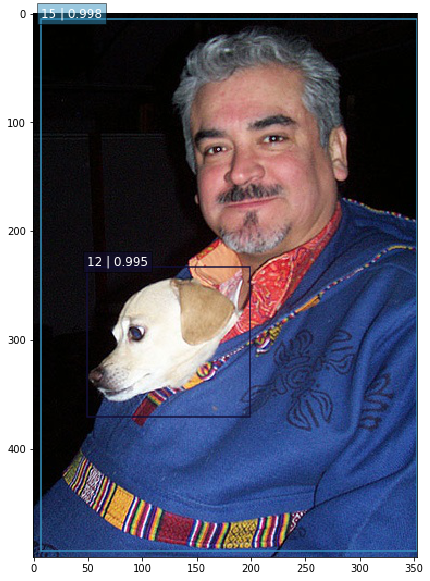

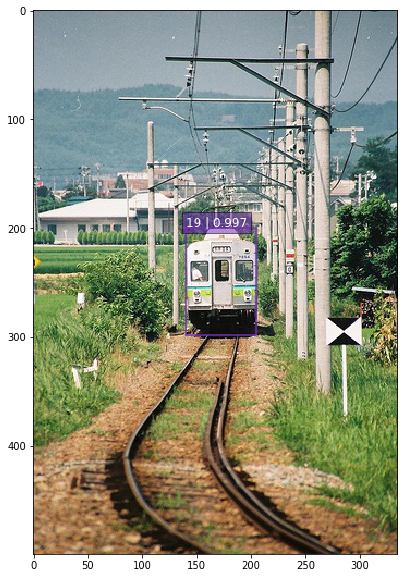

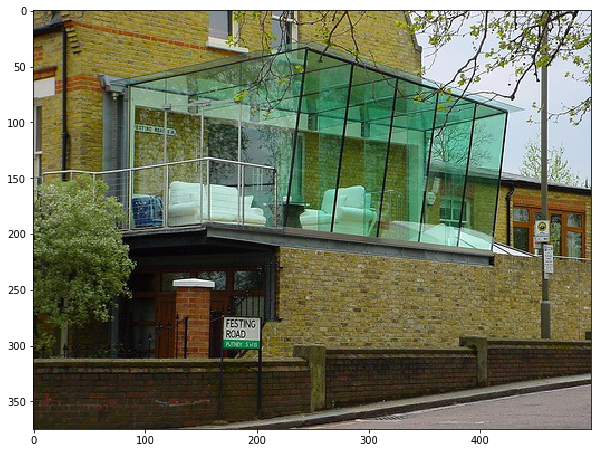

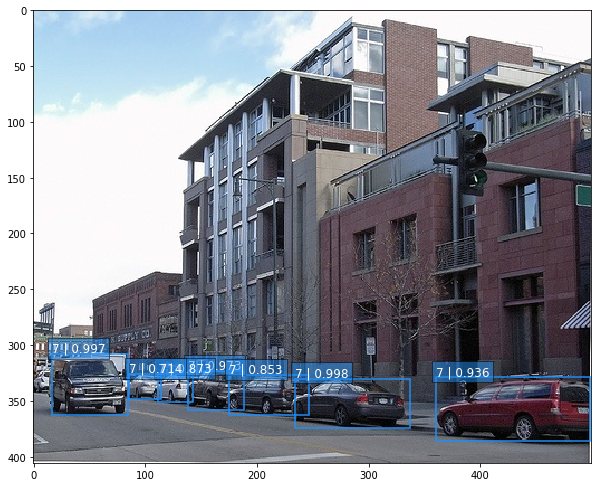

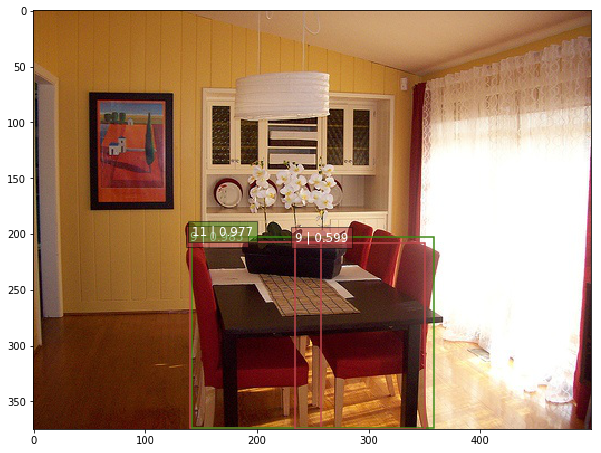

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


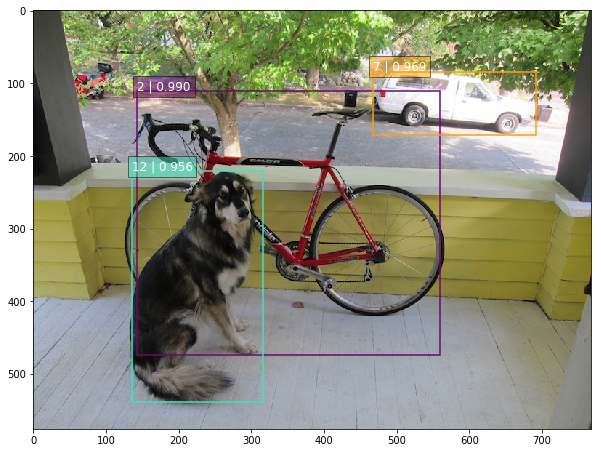

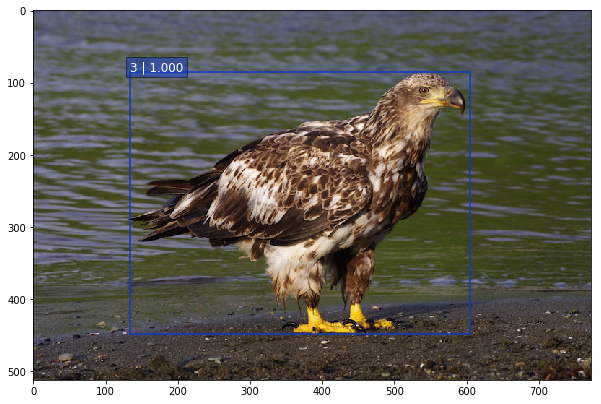

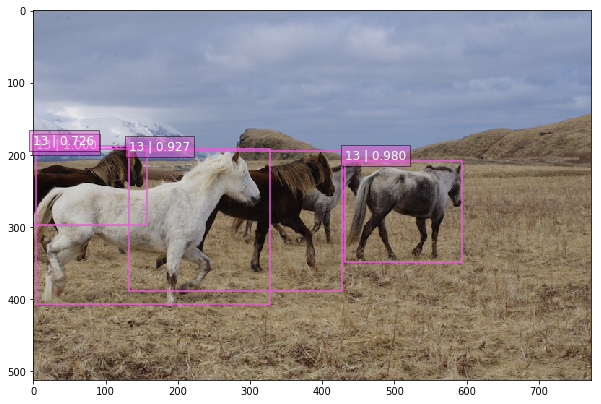

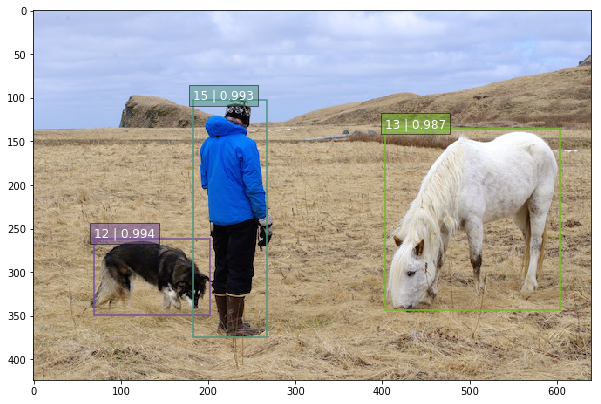

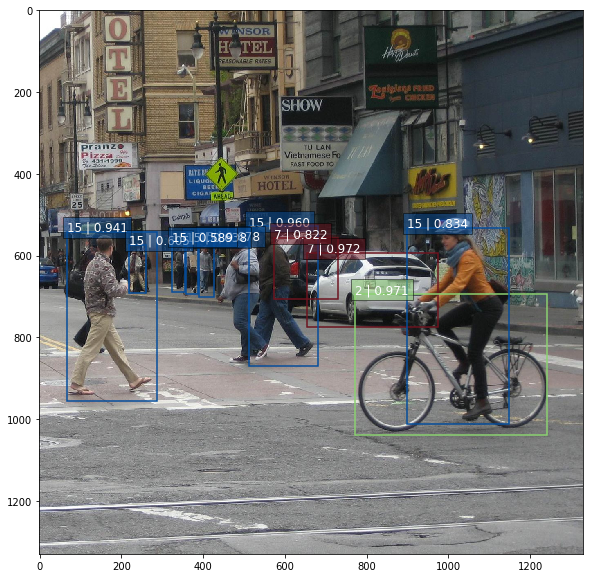

In [9]:
# Test on some demo image and visualize output.
path = '../demo/'
image_names = sorted(os.listdir(path))

for i in range(len(image_names)):
    img = mpimg.imread(path + image_names[i])
    rclasses, rscores, rbboxes =  process_image(img)

    # visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
    visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

# Apply pipeline on video

In [10]:
def plt_bboxes(img, classes, scores, bboxes, figsize=(10,10), linewidth=1.5):

    height = img.shape[0]
    width = img.shape[1]
    colors = dict()
    for i in range(classes.shape[0]):
        cls_id = int(classes[i])
        if cls_id ==7:
            score = scores[i]
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            ymin = int(bboxes[i, 0] * height)
            xmin = int(bboxes[i, 1] * width)
            ymax = int(bboxes[i, 2] * height)
            xmax = int(bboxes[i, 3] * width)
            cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (0,100,205), 2)
            cv2.putText(img, "Car:"+str(round(score,2)), (xmin , ymin), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,0,255),2)
    return img

In [11]:
def pipeline(image):
    img = np.copy(image)
    rclasses, rscores, rbboxes =  process_image(img)
    # visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
    img_draw = plt_bboxes(img, rclasses, rscores, rbboxes)
    return img_draw

In [15]:
from moviepy.editor import VideoFileClip

# Convert to video
# vid_output is where the image will be saved to
vid_output = '../vehicle_detection_ssd.mp4'
# vid_output = 'vehicle_detection_uNet_bbox_BN.mp4'

# The file referenced in clip1 is the original video before anything has been done to it
clip1 = VideoFileClip("../project_video.mp4")

# NOTE: this function expects color images
vid_clip = clip1.fl_image(pipeline) 
%time vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video ../vehicle_detection_ssd.mp4
[MoviePy] Writing video ../vehicle_detection_ssd.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:00<00:00, 10.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../vehicle_detection_ssd.mp4 

Wall time: 2min 1s


In [16]:
from moviepy.editor import VideoFileClip

# Convert to video
# vid_output is where the image will be saved to
vid_output = '../challenge_video_ssd.mp4'
# vid_output = 'vehicle_detection_uNet_bbox_BN.mp4'

# The file referenced in clip1 is the original video before anything has been done to it
clip1 = VideoFileClip("../challenge_video.mp4")

# NOTE: this function expects color images
vid_clip = clip1.fl_image(pipeline) 
%time vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video ../challenge_video_ssd.mp4
[MoviePy] Writing video ../challenge_video_ssd.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [00:46<00:00, 10.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../challenge_video_ssd.mp4 

Wall time: 47.2 s
